# Tutorial 2: Linear, logistic regression

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import sklearn.datasets as skdatasets
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# 1. Linear regression

### 1.1. Load dataset

In [72]:
def load_diabetes():
    # https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html
    X, y = skdatasets.load_diabetes(return_X_y=True)
    # select the 2nd features
    X = X[:, 2].reshape(-1, 1)
    y = y.reshape(-1, 1)
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_diabetes(x, y, yhat=None):
    x = x.ravel()
    y = y.ravel()
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='tab:blue')
    plt.title('Linear Regression (Diabetes dataset)', fontsize=18, pad=12)
    plt.xlabel('x: BMI', fontsize=16, labelpad=12)
    plt.ylabel('y: Disease progression', fontsize=16, labelpad=12)
    if yhat is not None:
        yhat = yhat.ravel()
        idx = np.argsort(x)
        plt.plot(x[idx], yhat[idx], c='tab:orange', label='Predicted')
        plt.legend(fontsize=14, loc='upper right')
    plt.show()

In [73]:
X_train, X_test, y_train, y_test = load_diabetes()

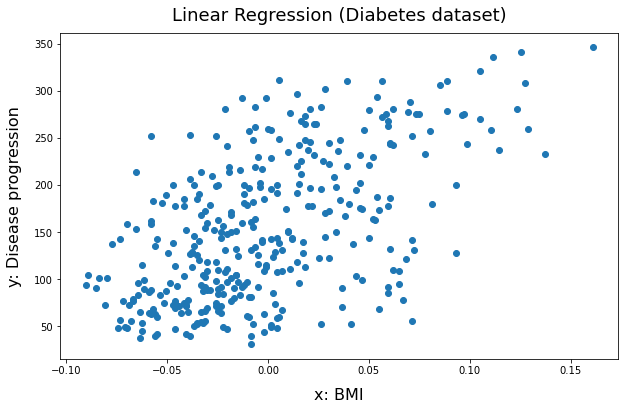

In [74]:
plot_diabetes(X_train, y_train)

In [75]:
print(X_train[:5, :])
# x의 왼편에 one vector 더해줘야함

[[-0.02021751]
 [-0.046085  ]
 [-0.03422907]
 [-0.0191397 ]
 [-0.0547075 ]]


### 1.2. Solve normal equation

$$
y = 
\begin{bmatrix} 
    y_1 \\ y_2 \\ \vdots \\ y_n
\end{bmatrix}, \quad
X =
\begin{bmatrix}
    1 \quad x_1 \\
    1 \quad x_2 \\
    \vdots \\
    1 \quad x_n
\end{bmatrix}, \quad
w =
\begin{bmatrix}
    w_0 \\ w_1
\end{bmatrix}
$$

In [76]:
def prepend_one_vector(X):
    return np.c_[np.ones((len(X), 1)), X]


* **Q.1 (1 point)**: Solve normal equation $w = (X^TX)^{-1}X^Ty$

In [77]:
def solve_linear_regression(X, y):
    # add one vector to X
    X = prepend_one_vector(X)
    '''solve normal equation (1 point)'''
    w=np.linalg.inv(X.T @ X)@(X.T @ y)
    return w

In [78]:
W = {'Naive': None}
W['Naive'] = solve_linear_regression(X_train, y_train)

In [79]:
print(tabulate(W, headers='keys', showindex=True))

      Naive
--  -------
 0  154.221
 1  931.477


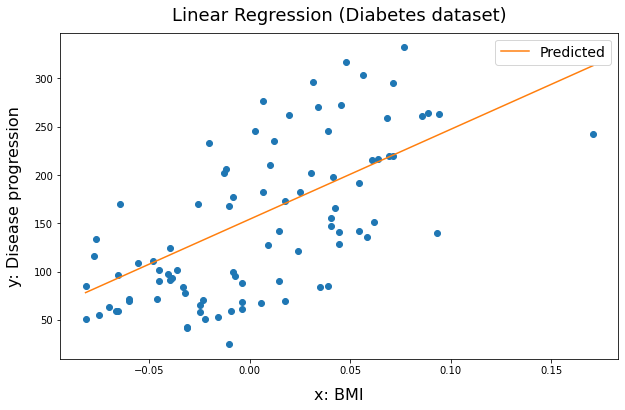

In [80]:
yhat = prepend_one_vector(X_test) @ W['Naive']
plot_diabetes(X_test, y_test, yhat)

### 1.3. Gradient descent

* **Q.2 (1 point)**: Initialize a weight matrix using ```np.random.rand()```
* **Q.3 (1 point)**: Compute $\hat{y} = X w$
* **Q.4 (1 point)**: Compute $dL/dw = X^T(\hat{y} - y)$
* **Q.5 (1 point)**: Update the weight matrix $w$ using gradient descent


In [81]:
def train_linear_regression(X, y, lr, epochs, log_every):
    # set seed
    np.random.seed(444)
    # add one vector
    X = prepend_one_vector(X)
    # shape
    _, in_features = X.shape
    '''initialize weights (1 point)'''
    w=np.random.rand(in_features,1)
    # begin training
    for e in range(1, epochs+1):
        '''compute yhat = X * W'''
        yhat=X@w 
        '''compute dL/dw = X^T * (yhat - y)'''
        dw=X.T @(yhat-y)
        ''' update w using gradient descent'''
        w-=lr*dw
        # print log
        if e % log_every == 0:
            loss = np.mean((yhat-y)**2)
            print(f'Epochs: {e}/{epochs}, loss: {loss:.4f}')
    return w

In [82]:
W['GD'] = train_linear_regression(X_train, y_train, lr=1e-3, epochs=10000, log_every=1000)

Epochs: 1000/10000, loss: 4343.0370
Epochs: 2000/10000, loss: 4024.6465
Epochs: 3000/10000, loss: 3957.1379
Epochs: 4000/10000, loss: 3942.8239
Epochs: 5000/10000, loss: 3939.7889
Epochs: 6000/10000, loss: 3939.1454
Epochs: 7000/10000, loss: 3939.0090
Epochs: 8000/10000, loss: 3938.9800
Epochs: 9000/10000, loss: 3938.9739
Epochs: 10000/10000, loss: 3938.9726


In [83]:
print(tabulate(W, headers='keys', showindex=True))

      Naive       GD
--  -------  -------
 0  154.221  154.22
 1  931.477  931.078


# 2. Logistic regression (Iris dataset)

### 2.1. Load dataset

In [84]:
def load_iris(normalize):
    # import data
    X, y = skdatasets.load_iris(return_X_y=True)
    # only use setosa and versicolour
    X = X[(y==0) | (y==1)]
    y = y[(y==0) | (y==1)]
    # reshape
    y = y.reshape(-1, 1)
    # only use 1st & 3rd features
    X = X[:, [0, 2]]
    if normalize:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return train_test_split(X, y, test_size=0.2, random_state=444)

def plot_iris(X, y, x1_mesh=None, x2_mesh=None, y_mesh=None):
    x1, x2 = X[:, 0], X[:, 1]
    y = y.ravel()
    plt.figure(figsize=(10, 6))
    plt.scatter(x1[y==0], x2[y==0], c='tab:blue', marker='o', label='Setosa')
    plt.scatter(x1[y==1], x2[y==1], c='tab:orange', marker='^', label='Versicolour')
    if x1_mesh is not None:
        cmap = mplcolors.ListedColormap(['tab:blue', 'tab:orange'])
        plt.contourf(x1_mesh, x2_mesh, y_mesh, levels=2, cmap=cmap, alpha=0.3)
    plt.title('Softmax Regression (Iris dataset)', fontsize=18, pad=12)
    plt.xlabel('x1: Sepal length', fontsize=16, labelpad=12) # 1st feat
    plt.ylabel('x2: Petal length', fontsize=16, labelpad=12) # 3rd feat
    plt.legend(fontsize=14, loc='upper left')
    plt.show()

In [85]:
X_train, X_test, y_train, y_test = load_iris(normalize=True)

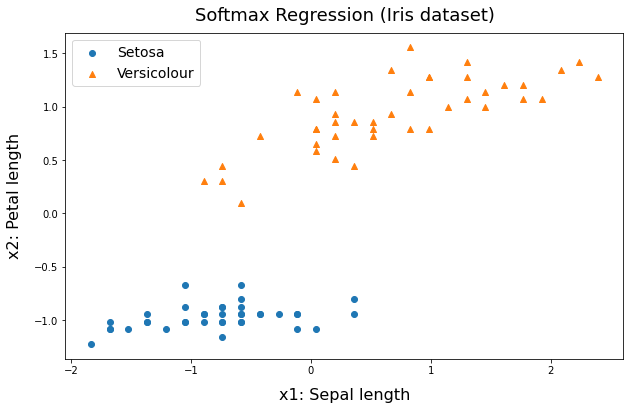

In [86]:
plot_iris(X_train, y_train)

### 2.2. Gradient descent

* **Q.6 (2 point)**: Compute $\text{sigmoid}(x) = 1 / (1 + e^{-x})$ 
* **Q.7 (2 point)**: Compute binary cross-entropy loss
$-\frac{1}{N} \sum_{i=1}^{N} y \cdot log(\hat{y}) + (1-y) \cdot log(1-\hat{y})$
* **Q.8 (1 point)**: Compute $\hat{y} = \sigma(Xw)$

In [97]:
def stable_sigmoid(x):
    # numerically stable version
    pos_mask = (x >= 0)
    neg_mask = (x <  0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def sigmoid(x):
    '''compute sigmoid(x) = 1 / (1+e^(-x))'''
    sigma=1/(1+np.exp(-x))
    return sigma

def binary_cross_entropy(yhat, y):
    # clip values to prevent divide by zero
    yhat = np.clip(yhat, a_min=1e-7, a_max=1-1e-7)
    '''compute binary cross-entropy loss'''
    loss=-np.mean(y*np.log(yhat)+(1-y)*np.log(1-yhat))
    return loss

def train_logistic_regression(X_train, X_test, y_train, y_test, lr, epochs, log_every):
    # set seed
    np.random.seed(444)
    # add one vector
    X_train = prepend_one_vector(X_train)
    X_test = prepend_one_vector(X_test)
    # shape
    _, in_features = X_train.shape
    # initialize weights
    w = np.random.rand(in_features, 1)
    # begin training
    for e in range(1, epochs+1):
        '''compute yhat'''
        yhat=sigmoid(X_train@w)
        # backward
        dw = X_train.T @ (yhat - y_train)
        # descent
        w -= lr * dw
        # print log
        if e % log_every == 0:
            yhat = sigmoid(X_test @ w)
            accr = np.mean(np.round(yhat) == y_test)
            loss = binary_cross_entropy(yhat, y_test)
            print(f'Epochs: {e}/{epochs}, loss (test): {loss:.4f}, accuracy (test): {accr:.4f}')
    return w

In [98]:
w = train_logistic_regression(X_train, X_test, y_train, y_test, lr=1e-2, epochs=10, log_every=1)

Epochs: 1/10, loss (test): 0.7353, accuracy (test): 0.9211
Epochs: 2/10, loss (test): 0.5873, accuracy (test): 0.9386
Epochs: 3/10, loss (test): 0.4944, accuracy (test): 0.9474
Epochs: 4/10, loss (test): 0.4052, accuracy (test): 0.9474
Epochs: 5/10, loss (test): 0.2894, accuracy (test): 0.9386
Epochs: 6/10, loss (test): 0.2583, accuracy (test): 0.9474
Epochs: 7/10, loss (test): 0.2424, accuracy (test): 0.9474
Epochs: 8/10, loss (test): 0.2300, accuracy (test): 0.9474
Epochs: 9/10, loss (test): 0.2202, accuracy (test): 0.9474
Epochs: 10/10, loss (test): 0.2125, accuracy (test): 0.9561


In [89]:
def compute_decision_boundary(X, w, resolution):
    x1, x2 = X[:, 0], X[:, 1]
    x1_mesh = np.linspace(np.min(x1) - 0.1, np.max(x1) + 0.1, resolution)
    x2_mesh = np.linspace(np.min(x2) - 0.1, np.max(x2) + 0.1, resolution)
    x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh, indexing='xy')
    X = prepend_one_vector(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
    y_mesh = np.round(sigmoid(X @ w)).reshape(resolution, resolution)
    return x1_mesh, x2_mesh, y_mesh

In [90]:
x1_mesh, x2_mesh, y_mesh = compute_decision_boundary(X_test, w, resolution=500)

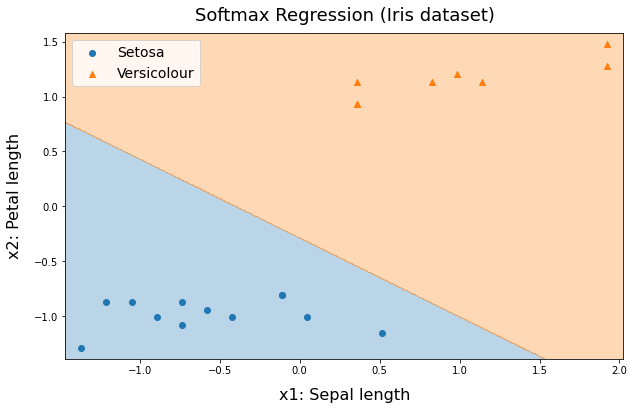

In [91]:
plot_iris(X_test, y_test, x1_mesh, x2_mesh, y_mesh)

# 3. Logistic regression (breast cancer)

### 3.1. Load dataset

In [92]:
def load_breast_cancer(normalize):
    # https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
    X, y = skdatasets.load_breast_cancer(return_X_y=True)
    y = y.reshape(-1, 1)
    if normalize:
        X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return train_test_split(X, y, test_size=0.2, random_state=444)

In [93]:
X_train, X_test, y_train, y_test = load_breast_cancer(normalize=True)

### 3.2. Gradient descent

In [94]:
w = train_logistic_regression(X_train, X_test, y_train, y_test, lr=1e-2, epochs=10, log_every=1)

Epochs: 1/10, loss (test): -0.0000, accuracy (test): 0.9211
Epochs: 2/10, loss (test): -0.0000, accuracy (test): 0.9386
Epochs: 3/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 4/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 5/10, loss (test): -0.0000, accuracy (test): 0.9386
Epochs: 6/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 7/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 8/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 9/10, loss (test): -0.0000, accuracy (test): 0.9474
Epochs: 10/10, loss (test): -0.0000, accuracy (test): 0.9561


# 4. Optional readings

*   [Solving Least-Squares with QR](https://johnwlambert.github.io/least-squares/)
*   [Understanding Linear Regression using the Singular Value Decomposition](https://sthalles.github.io/svd-for-regression/)
*   [Do we need gradient descent to find the coefficients of a linear regression model?](https://stats.stackexchange.com/questions/160179/do-we-need-gradient-descent-to-find-the-coefficients-of-a-linear-regression-mode)
*    [Why is logistic regression considered a linear model](http://www.ciaburro.it/why-is-logistic-regression-considered-a-linear-model/)